In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model_based.train import make_train, HyperParams, EquiModel, Model, SARSDTuple, make_catch_bce_loss_fn, make_catch_accuracy_loss_fn, CatchModel
from model_based.sample_env import make_experience_fn, make_expert_experience_fn
import pickle
import jax
import jax.numpy as jnp
import base_rl.higher_order as ho
from base_rl.models import ActorCritic
import matplotlib
from gymnax.environments.bsuite import Catch

In [2]:
cfg = ho.CONFIG
cfg["ENV"] = Catch()
cfg["ENV_PARAMS"] = Catch().default_params
train_fn = jax.jit(ho.make_train(cfg, ActorCritic))
result = train_fn(jax.random.PRNGKey(42))

2023-08-04 14:43:12.296432: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-08-04 14:43:12.296507: E external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.54.3 does not match DSO version 535.86.5 -- cannot find working devices in this configuration
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
runner_state= result["runner_state"]
expert_params = runner_state[0].params

In [4]:
num = 2000
keys = jax.random.split(jax.random.PRNGKey(42), num)
random_data = jax.jit(jax.vmap(make_experience_fn("Catch-bsuite", 500)))(keys)
random_data_len = np.prod(random_data.reward.shape)
random_data = jax.tree_map(lambda x: x.reshape((random_data_len, -1)), random_data)
# non_zero = (random_data.done == 0).reshape(-1)
# random_data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), random_data )

expert_data = jax.jit(jax.vmap(make_expert_experience_fn("Catch-bsuite", 500, expert_params)))(keys)
expert_data_len= np.prod(expert_data.reward.shape)
expert_data= jax.tree_map(lambda x: x.reshape((expert_data_len, -1)), expert_data)

/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [5]:
hyp = HyperParams(model=Model, train_frac=0.8)
data = random_data.join(expert_data)
data_len = np.prod(data.reward.shape)
data = jax.tree_map(lambda x: x.reshape(data_len, -1), data)
perm = np.random.permutation(data_len)
data = jax.tree_map(lambda x: x.at[perm, ...].get(), data)

# non_zero = (data.done ==0).reshape(-1)
# data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), data)



train_data, val_data = data.partition(hyp.get_train_size(data))
filtered_data = train_data.filter_by_action(0)

# jax.tree_map(lambda x: print(x.shape), train_data)
# jax.tree_map(lambda x: print(x.shape), val_data)

In [6]:
def train_model(hyp, train_data, val_data):
    train = make_train(hyp, train_data, val_data, loss_function_ho=make_catch_bce_loss_fn, val_loss_function_ho=make_catch_accuracy_loss_fn)
    result = train(jax.random.PRNGKey(42))
    losses = result[1][0]
    return losses.train_loss.reshape(-1), losses.val_loss.reshape(-1), result[0] 
def get_x(loss, epoch):
    return np.linspace(0, epoch, len(loss))

In [7]:
EPCH=100
hyp = HyperParams(model=CatchModel, train_frac=1, epochs=EPCH, learning_rate=1e-5)
# hyp_equi = HyperParams(model=EquiModel, train_frac=1, epochs=EPCH, learning_rate=1e-5)
hyps = [ hyp, ]
datas = [train_data, filtered_data, random_data]


In [8]:
moving_average = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w
cs = ["blue", "indigo"]
sol =[]
models = {}
for hyp, c in zip(hyps, cs):
    sub_sol = []
    for i, data in enumerate(datas):
        train_loss, val_loss, runner_state= train_model(hyp, data, val_data)
        sub_sol.append((train_loss, val_loss))
        models[(hyp.model.__name__, i)] =runner_state 
        
    sol.append(sub_sol)

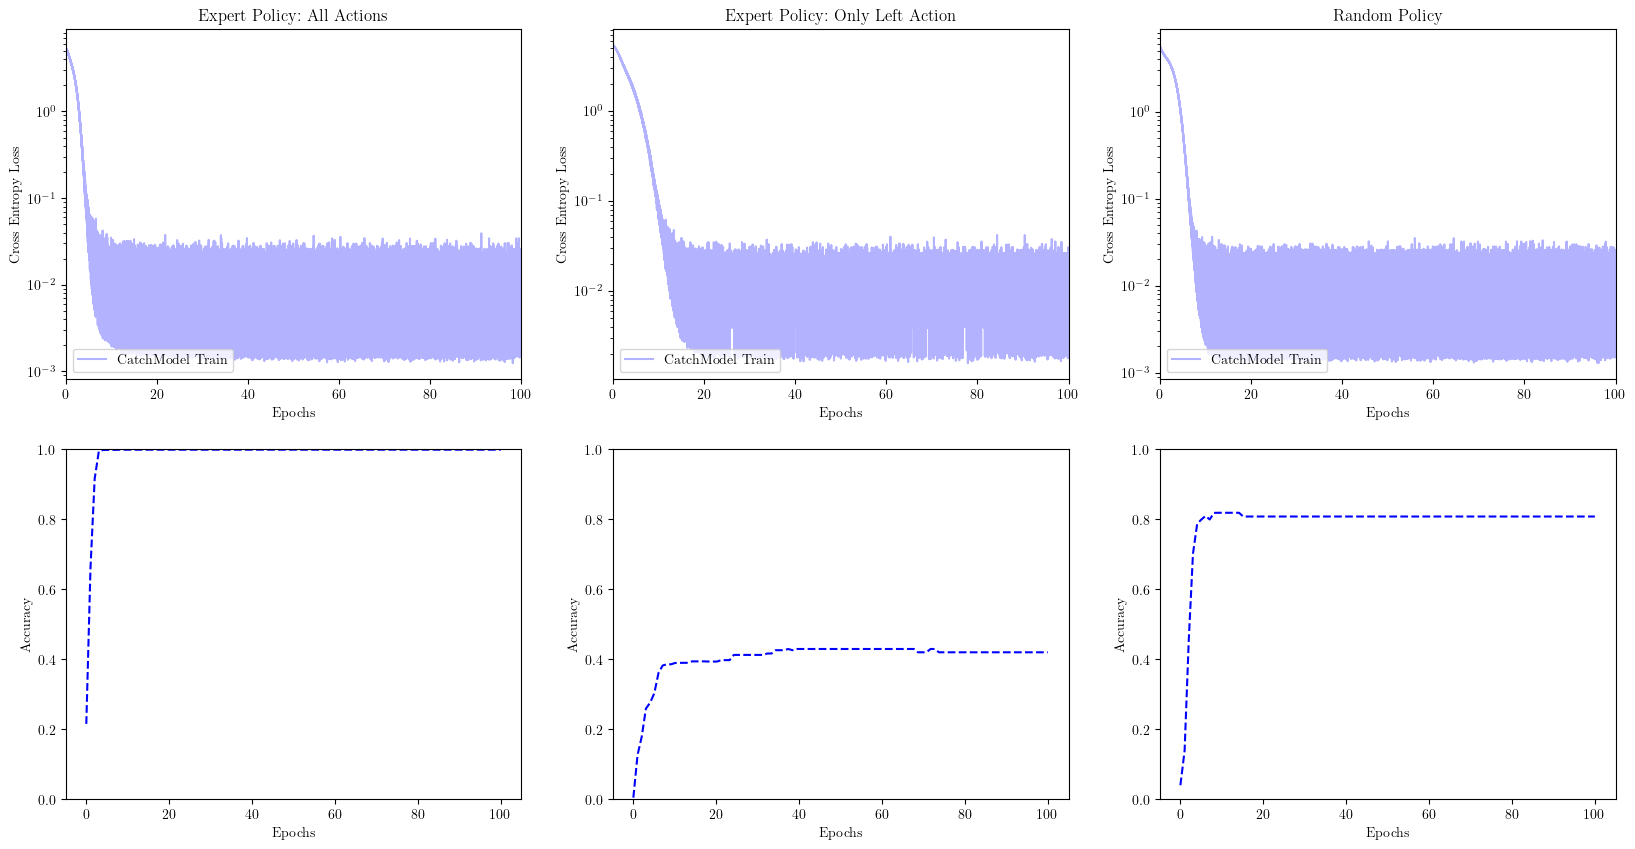

In [9]:
matplotlib.rcParams.update( {"text.usetex": True, "font.family": "serif",})
titles = ["Expert Policy: All Actions", "Expert Policy: Only Left Action", "Random Policy"]
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for sub_sol, hyp, c in zip(sol, hyps, cs):
    for i, ((train_loss, val_loss), tit) in enumerate(zip(sub_sol, titles)):
        train_loss= moving_average(train_loss, 10)
        ax[0, i].semilogy(get_x(train_loss, hyp.epochs),train_loss, label=f"{hyp.model.__name__} Train", color=c, alpha = 0.3)
        if tit == "Random Policy":
            ax[1, i].plot(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Expert Policy Validation", color=c, linestyle="--")
        else: 
            ax[1, i].plot(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Val", color=c, linestyle="--")
        ax[0, i].legend(loc="lower left")
        ax[0, i].set_xlabel("Epochs")
        ax[1, i].set_xlabel("Epochs")
        ax[0, i].set_ylabel("Cross Entropy Loss")
        ax[1, i].set_ylabel("Accuracy")
        ax[0, i].set_title(tit)
        ax[0, i].set_xlim(0, EPCH)
        ax[1, i].set_ylim(0, 1)



In [10]:
rng = jax.random.PRNGKey(42)
key = jax.random.split(rng, 500)
train = jax.jit(ho.make_train(ho.CONFIG, ActorCritic))

result = train(rng)
runner_state= result["runner_state"]


# Catch Playground

In [11]:
env = Catch()
env_params = env.default_params
ts = models[("CatchModel", 0)][1]

In [12]:
def pred(ball_dist, pad_dist):
    sol_ball = jnp.zeros_like(ball_dist.probs).at[ball_dist.mode()].set(1)
    sol_pad = jnp.zeros_like(pad_dist.probs).at[pad_dist.mode()].set(1)
    sol = jnp.concatenate([sol_ball.reshape(-1), sol_pad.reshape(-1)], axis=0)

    return sol.reshape(-1, 10, 5)
accs = []
num_envs = 50
key = jax.random.PRNGKey(0)
key = jax.random.split(key, num_envs)
obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(key, env_params)
aply = jax.jit(ts.apply_fn)
other_acc = []
for i in range(100):
    key = jax.vmap(jax.random.split, in_axes=(0))(key)[:, -1]
    action = jax.random.randint(key[0], minval=0, maxval=3, shape=(num_envs,))
    ball_dist, pad_dist = aply(ts.params, obs.reshape(-1, 50), action)

    prediction = jax.vmap(pred, in_axes=0)(ball_dist, pad_dist)
    obs, env_state, rew, done, info = jax.vmap(env.step)(key, env_state, action)

    obs= obs.reshape(-1, 50)
    ball= obs.at[..., :45].get()
    ball_pred = ball_dist.mode()
    pad_pred = pad_dist.mode()
    pad= obs.at[..., 45:].get()
    ball_acc = ball_pred == jnp.where(ball==1.0)[1]
    pad_acc = pad_pred == jnp.where(pad ==1.0)[1]
    
    acc = jnp.logical_and(ball_acc, pad_acc).mean()
    other_acc.append(acc)



    sol = jnp.mean((prediction.reshape(-1, 50) == obs.reshape(-1, 50)).all(axis=-1))
    accs.append(sol)

print(sum(ac for ac in accs) / len(accs) )
print(sum(ac for ac in other_acc) / len(other_acc) )



0.6092003
0.6092003
